In [4]:
# Instalasi library hdbscan (tidak tersedia default di sklearn)
!pip install hdbscan

# Import modul
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import hdbscan

Langkah 1 - Membuat Fungsi Visualisasi

In [5]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # warna hitam untuk noise
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

Langkah 3 - Membuat Data Sintetis
Dataset terdiri dari 3 buah cluster Gaussian.

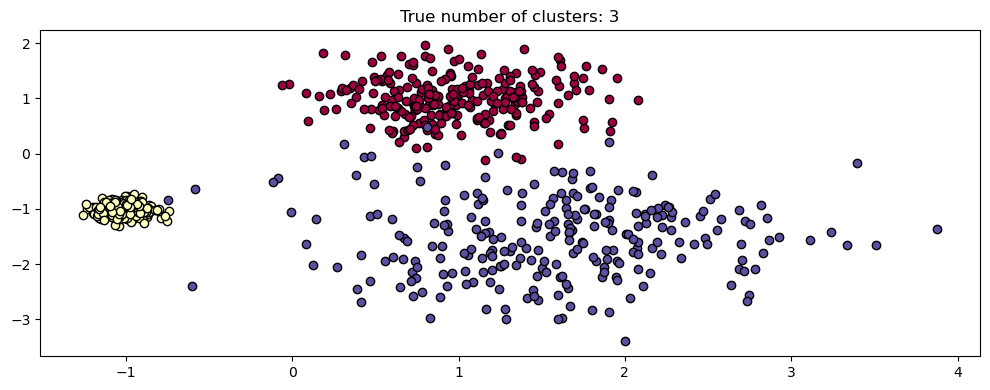

In [6]:
centers = [[1, 1], [-1, -1], [1.5, -1.5]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.4, 0.1, 0.75], random_state=0
)

plot(X, labels=labels_true, ground_truth=True)

Langkah 4 - Uji Scale Invariance Pada Model DBSCAN

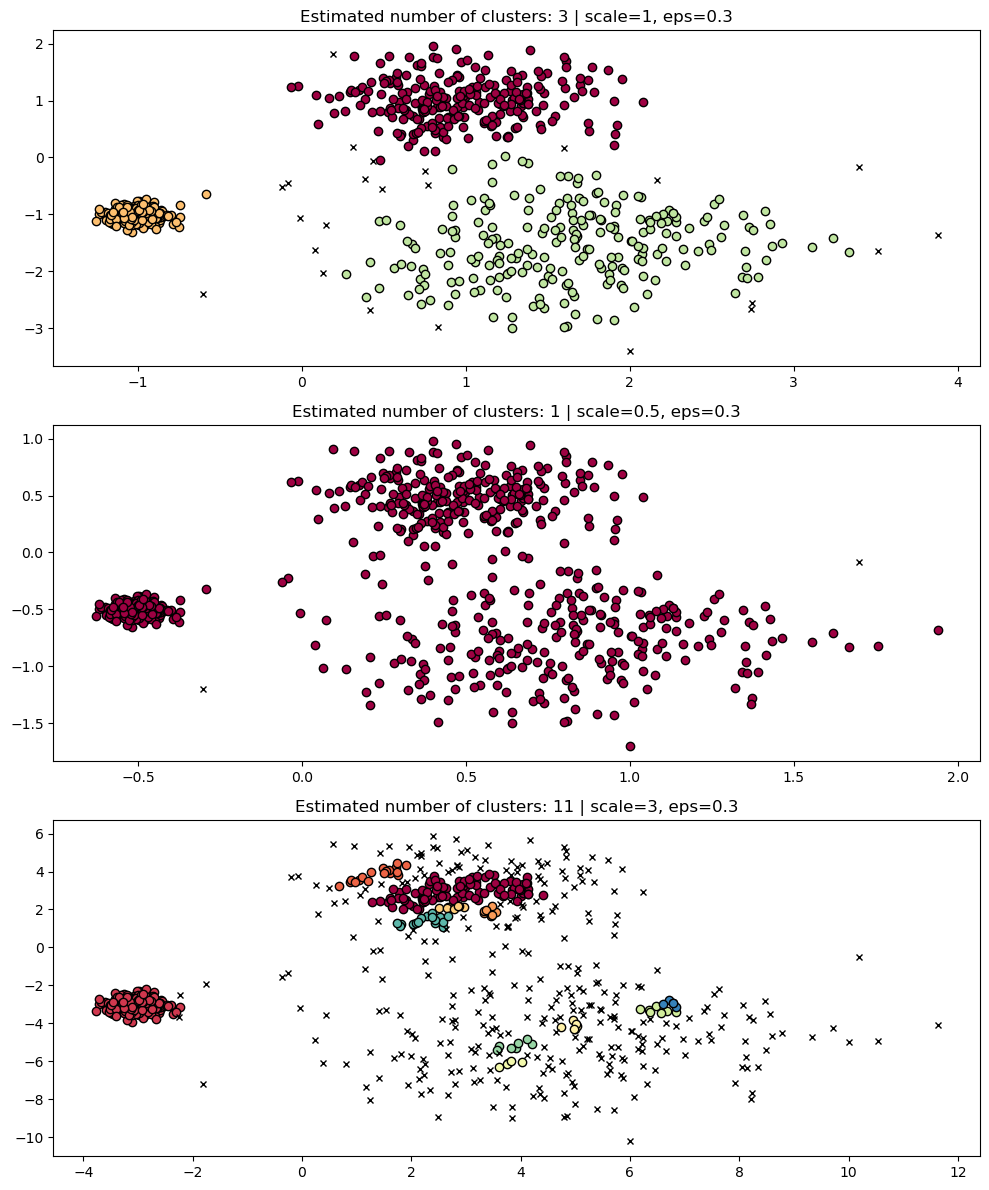

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
dbs = DBSCAN(eps=0.3)
for idx, scale in enumerate([1, 0.5, 3]):
    dbs.fit(X * scale)
    plot(X * scale, dbs.labels_, parameters={"scale": scale, "eps": 0.3}, ax=axes[idx])

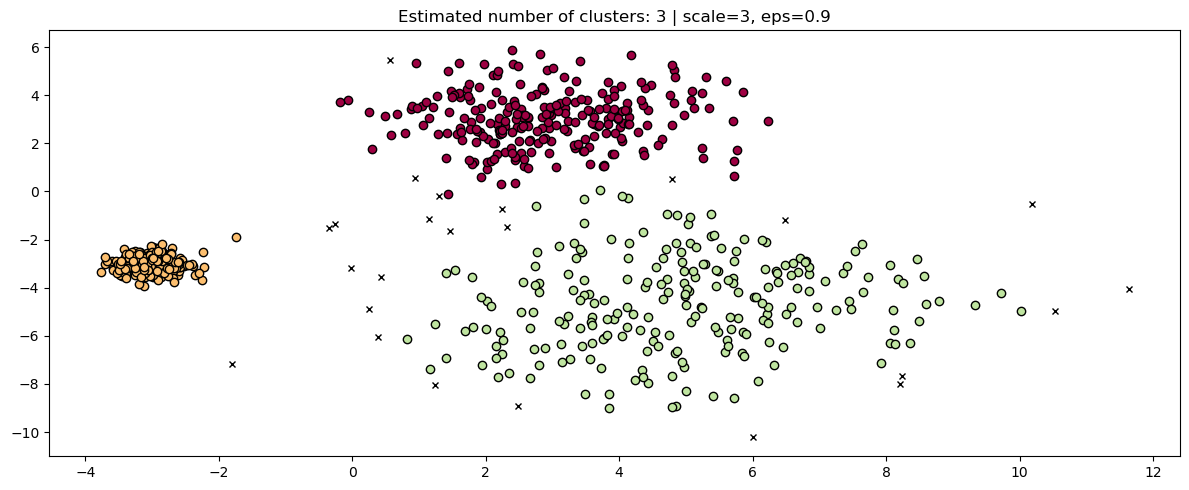

In [8]:
fig, axis = plt.subplots(1, 1, figsize=(12, 5))
dbs = DBSCAN(eps=0.9).fit(3 * X)
plot(3 * X, dbs.labels_, parameters={"scale": 3, "eps": 0.9}, ax=axis)

Langkah 5 - Membuat Model HDBSCAN

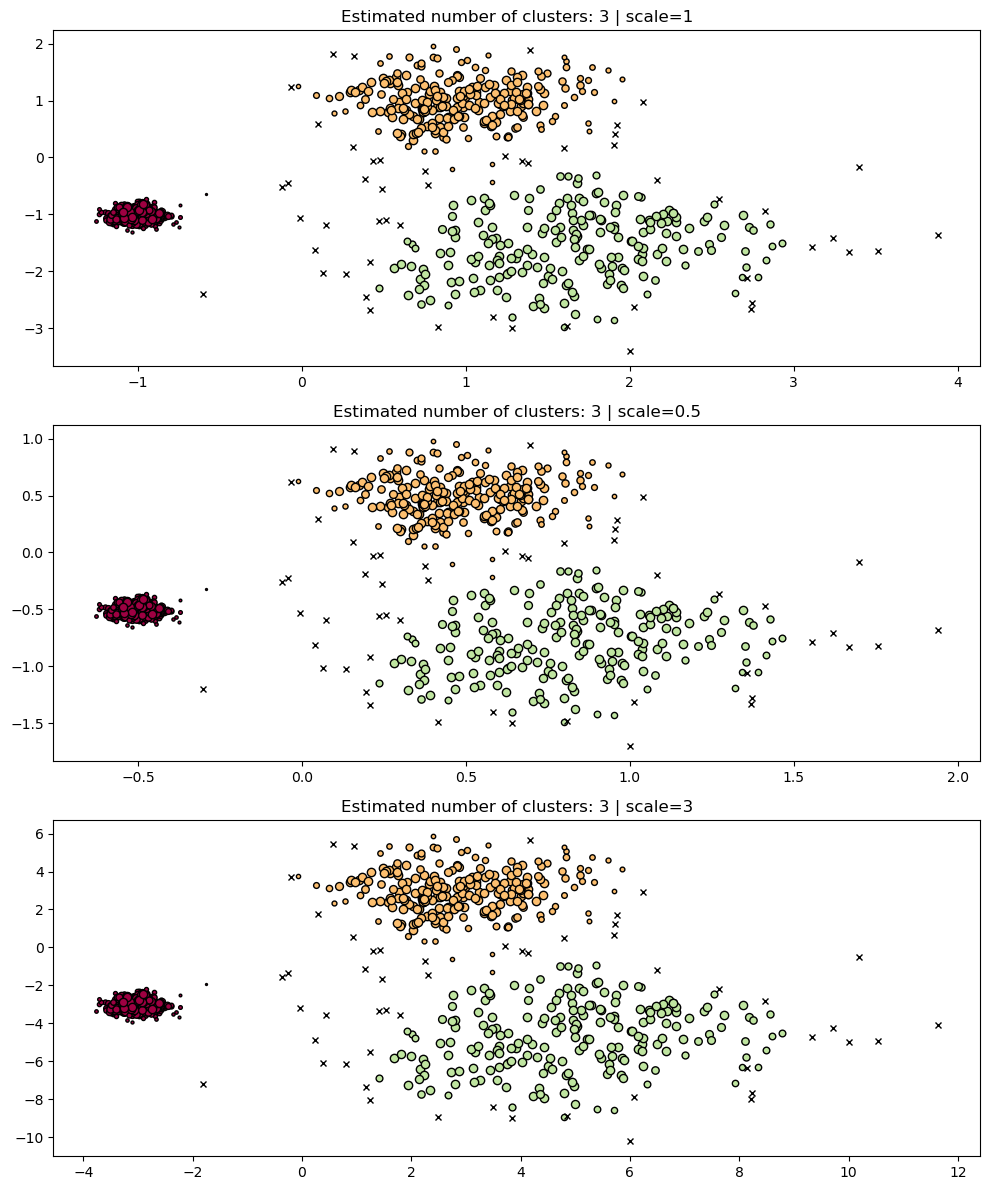

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
hdb = hdbscan.HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
    hdb.fit(X * scale)
    plot(X * scale, hdb.labels_, hdb.probabilities_, ax=axes[idx], parameters={"scale": scale})

Langkah 6 - Multiscale Clustering

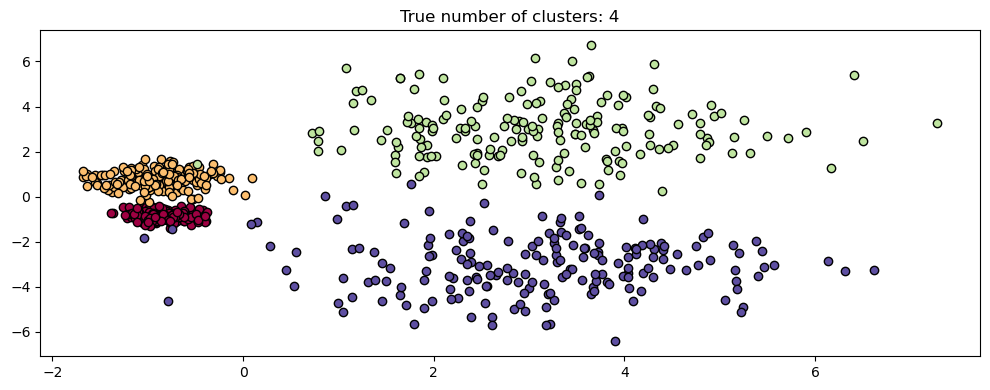

In [10]:
centers = [[-0.85, -0.85], [-0.85, 0.85], [3, 3], [3, -3]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.2, 0.35, 1.35, 1.35], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

Bandingkan DBSCAN dengan eps berbeda:

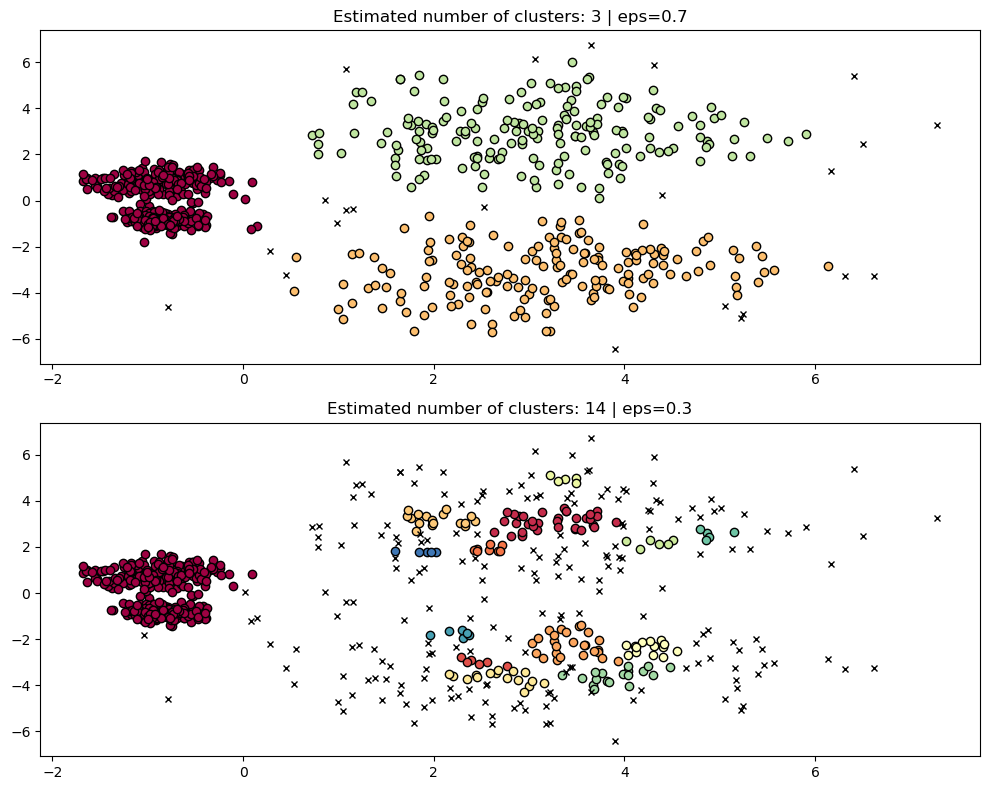

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
params = {"eps": 0.7}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[0])

params = {"eps": 0.3}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[1])

Jalankan HDBSCAN:

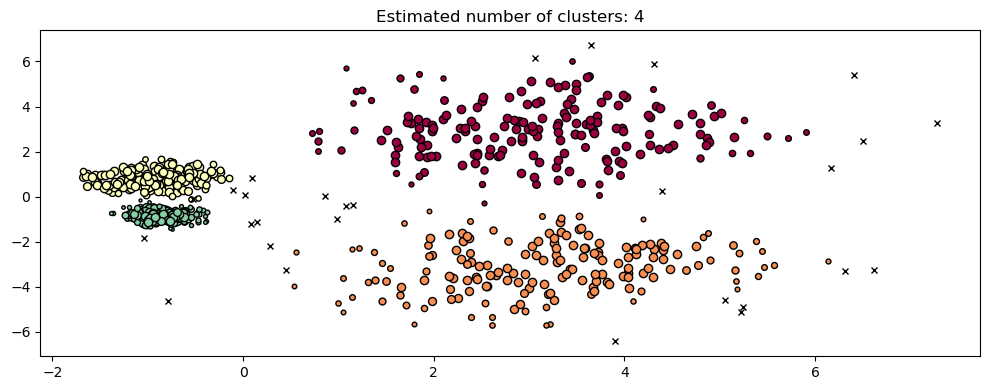

In [12]:
hdb = hdbscan.HDBSCAN().fit(X)
plot(X, hdb.labels_, hdb.probabilities_)

Langkah 7 - Eksperimen Hyperparameter min_cluster_size

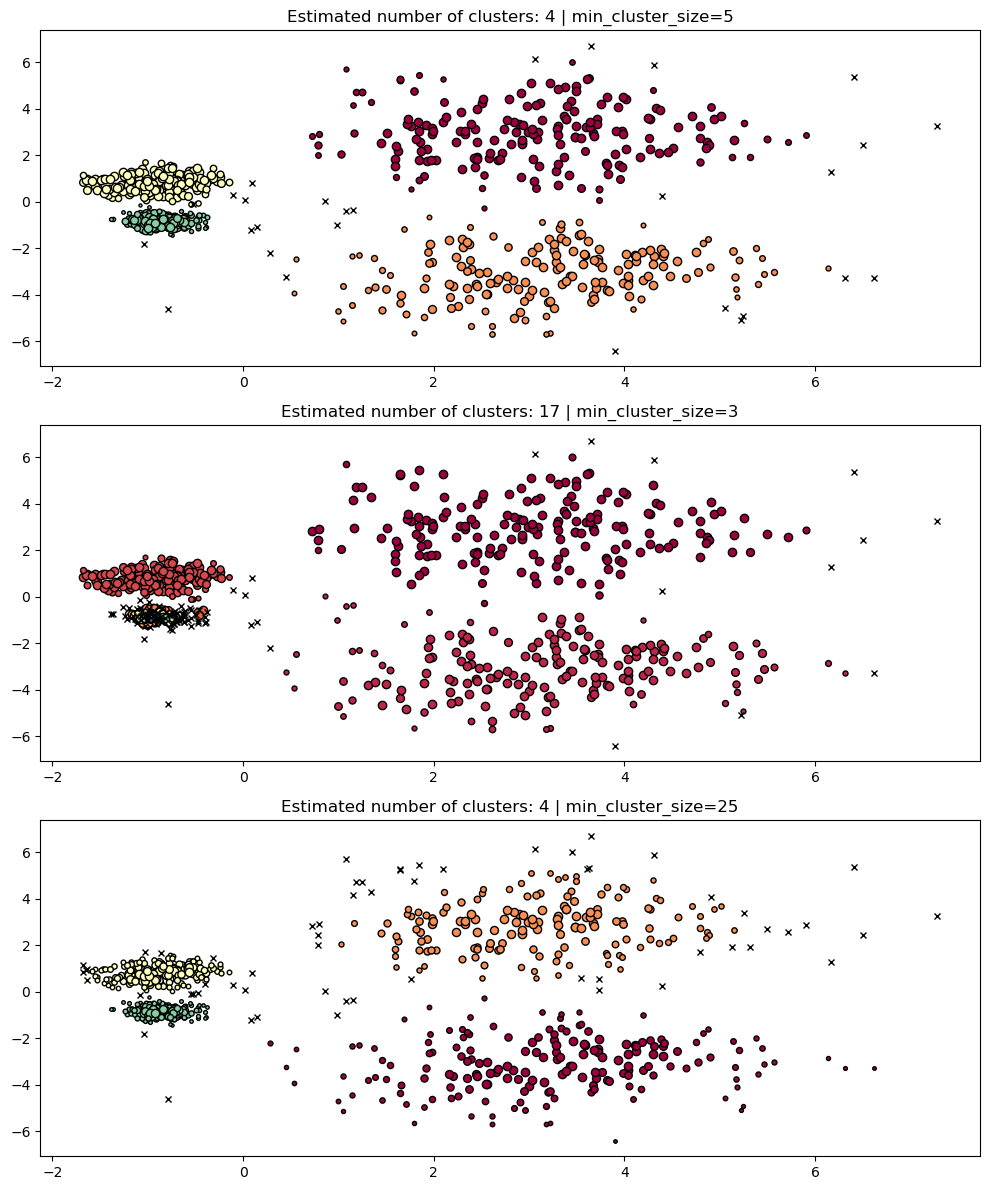

In [13]:
PARAM = ({"min_cluster_size": 5}, {"min_cluster_size": 3}, {"min_cluster_size": 25})
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = hdbscan.HDBSCAN(**param).fit(X)
    plot(X, hdb.labels_, hdb.probabilities_, param, ax=axes[i])

Langkah 8: Eksperimen Hyperparameter min_samples

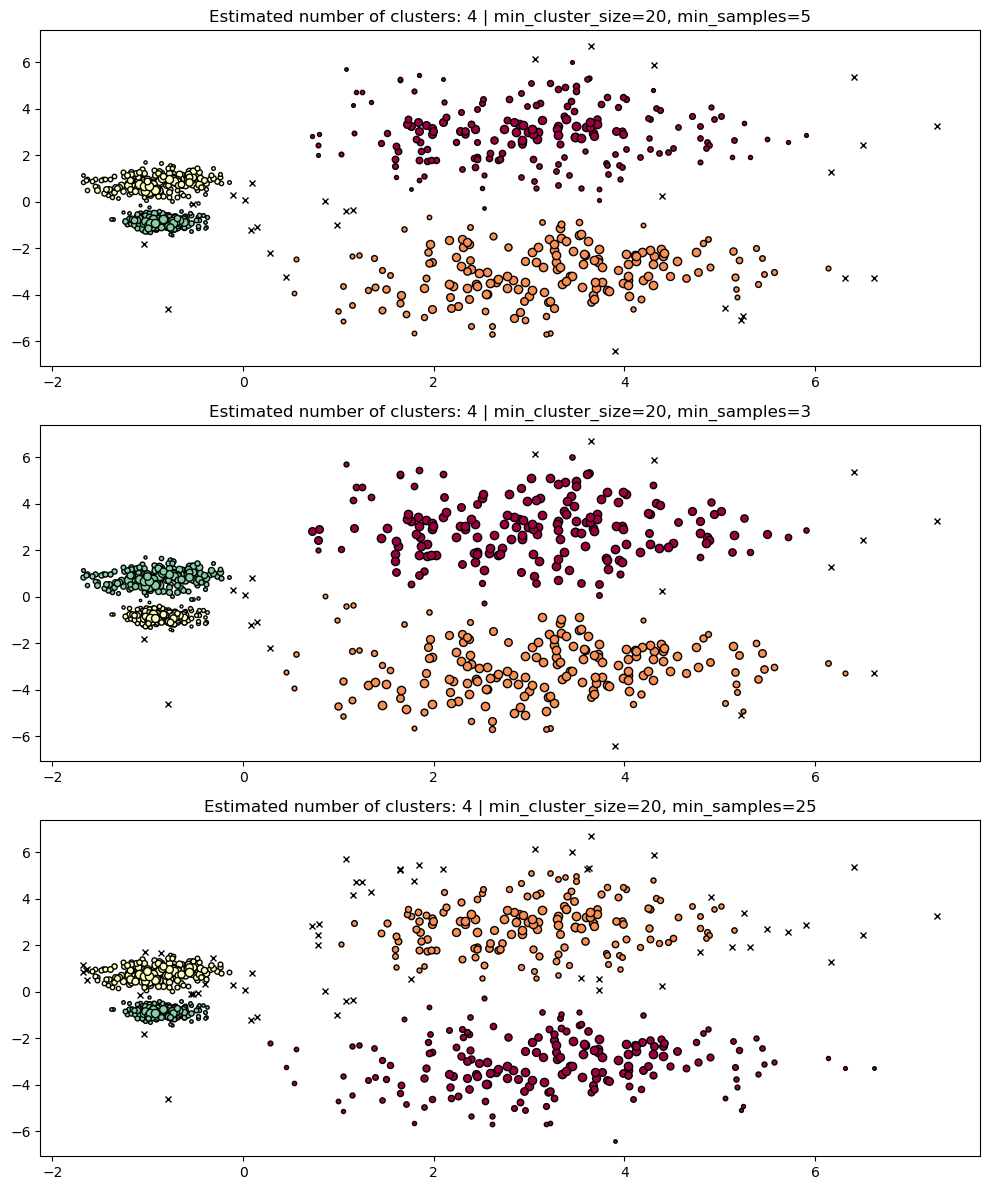

In [14]:
PARAM = (
    {"min_cluster_size": 20, "min_samples": 5},
    {"min_cluster_size": 20, "min_samples": 3},
    {"min_cluster_size": 20, "min_samples": 25},
)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = hdbscan.HDBSCAN(**param).fit(X)
    plot(X, hdb.labels_, hdb.probabilities_, param, ax=axes[i])

Langkah 9 - DBSCAN Clustering dari Pohon HDBSCAN
Gunakan parameter cut_distance.

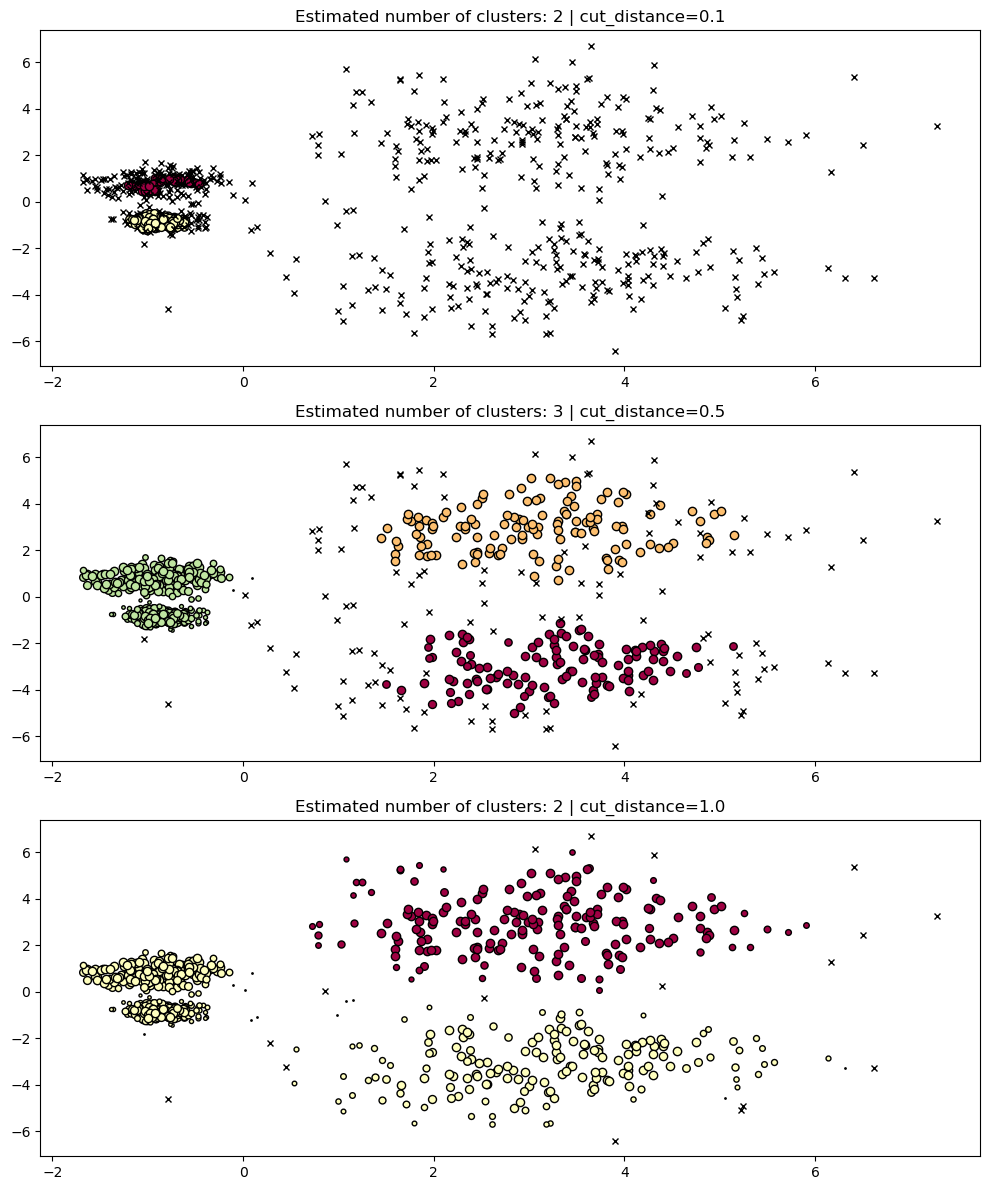

In [15]:
PARAM = (
    {"cut_distance": 0.1},
    {"cut_distance": 0.5},
    {"cut_distance": 1.0},
)
hdb = hdbscan.HDBSCAN().fit(X)
fig, axes = plt.subplots(len(PARAM), 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    labels = hdb.dbscan_clustering(**param)
    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

Langkah 10 -  Evaluasi dengan Silhouette Score

In [16]:
from sklearn.metrics import silhouette_score

# Menghitung Silhouette Score untuk hasil clustering HDBSCAN
sil_score = silhouette_score(X, hdb.labels_)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.574011299500838


Langkah 11 - Evaluasi dengan Davies-Bouldin Index

In [17]:
from sklearn.metrics import davies_bouldin_score

# Menghitung Davies-Bouldin Index untuk hasil clustering HDBSCAN
dbi_score = davies_bouldin_score(X, hdb.labels_)
print(f"Davies-Bouldin Index: {dbi_score}")

Davies-Bouldin Index: 1.617294745424524


Langkah 12 - Visualisasi Hasil Evaluasi

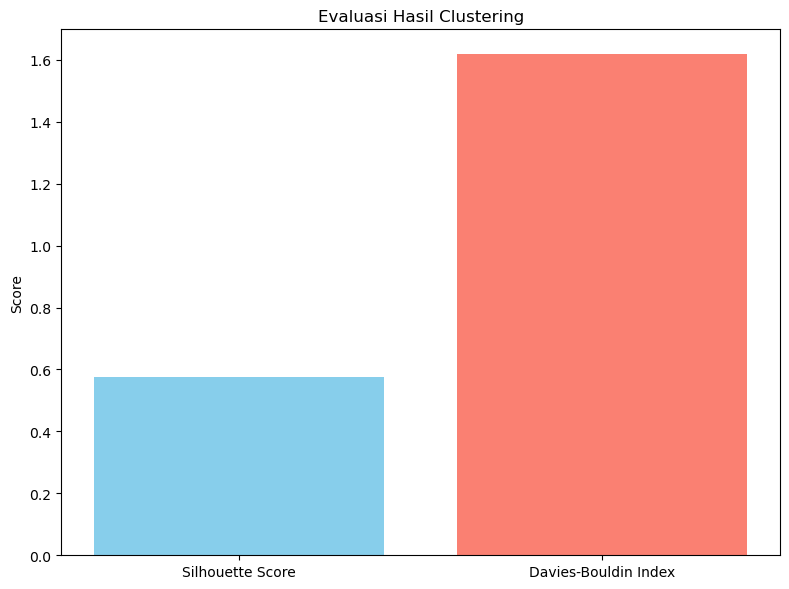

In [18]:
# Misalnya kita ingin membandingkan DBI dan Silhouette Score untuk beberapa eksperimen
scores = {
    "Silhouette Score": sil_score,
    "Davies-Bouldin Index": dbi_score
}

# Plot hasil evaluasi
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(scores.keys(), scores.values(), color=['skyblue', 'salmon'])
ax.set_title("Evaluasi Hasil Clustering")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()